# Импорт библиотек

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
from transformers import ViTForImageClassification
from transformers import ViTConfig, ViTForImageClassification
from datasets import load_dataset
from datasets import Dataset
from torch.utils.data import  Subset
import matplotlib.pyplot as plt
import itertools
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
import torch.optim as optim
from torchvision import models, transforms, datasets
from torchvision.models import resnet34, ResNet34_Weights

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DF = pd.read_excel('/content/data_8_30160.xlsx')
DF['id'] = DF['id'].fillna('').astype(str)
DF.to_excel('data_8_new.xlsx', index = False)

# Загрузка данных

In [ ]:
data = pd.read_excel("/content/data_8_new.xlsx")
data= Dataset.from_pandas(data)
data

Dataset({
    features: ['id', 'IRF', 'SRF', 'HE', 'CNV', 'PED', 'Drusen', 'ERM', 'MH, LMH'],
    num_rows: 3169
})

# Распределение по классам биомаркеров

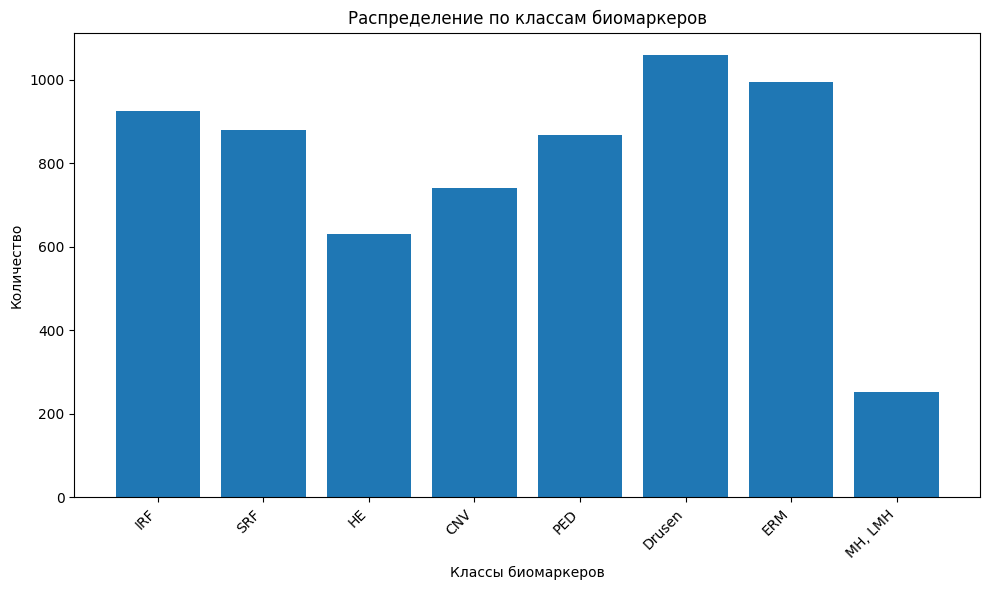

In [ ]:
dataset_no_id = data.remove_columns(["id"])
labels = ['IRF', 'SRF', 'HE', 'CNV', 'PED', 'Drusen', 'ERM', 'MH, LMH']
def plot_histogram(data_split):
        if not isinstance(data_split, Dataset):
            raise TypeError("data_split must be a Dataset object.")

        class_counts = {
            label: 0 for label in labels
        }

        for i in range(len(data_split)):
            sample = data_split[i]

            for label in labels:
                try:
                    class_counts[label] += sample[label]
                except KeyError as e:
                    print(f"KeyError: {e}. Обратите внимание на структуру данных.")
                    return

        classes = list(class_counts.keys())
        counts = list(class_counts.values())

        plt.figure(figsize=(10, 6))
        plt.bar(classes, counts)
        plt.xlabel('Классы биомаркеров')
        plt.ylabel('Количество')
        plt.title('Распределение по классам биомаркеров')
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

plot_histogram(dataset_no_id)


# Совместное рапределение биомаркеров

In [ ]:
from collections import defaultdict
def plot_combined_biomarkers(data_split):
    biomarkers_pairs = defaultdict(int)

    for entry in data_split:
        biomarkers = {key: value for key, value in entry.items() if key in labels}
        active_biomarkers = [biomarkers for biomarkers, value in biomarkers.items() if value > 0]

        for pair in itertools.combinations(sorted(active_biomarkers), 2):
            biomarkers_pairs[pair] += 1

    sorted_pairs = sorted(biomarkers_pairs.items(), key=lambda x: x[1], reverse=True)
    pairs = [f"{pair[0]} & {pair[1]}" for pair, _ in sorted_pairs]
    counts = [count for _, count in sorted_pairs]

    plt.figure(figsize=(18, 6))
    plt.bar(pairs[:20], counts[:20])
    plt.xlabel('Пары биомаркеров')
    plt.ylabel('Количество')
    plt.title('Совместное появление биомаркеров')
    plt.xticks(rotation=45)

    plt.show()


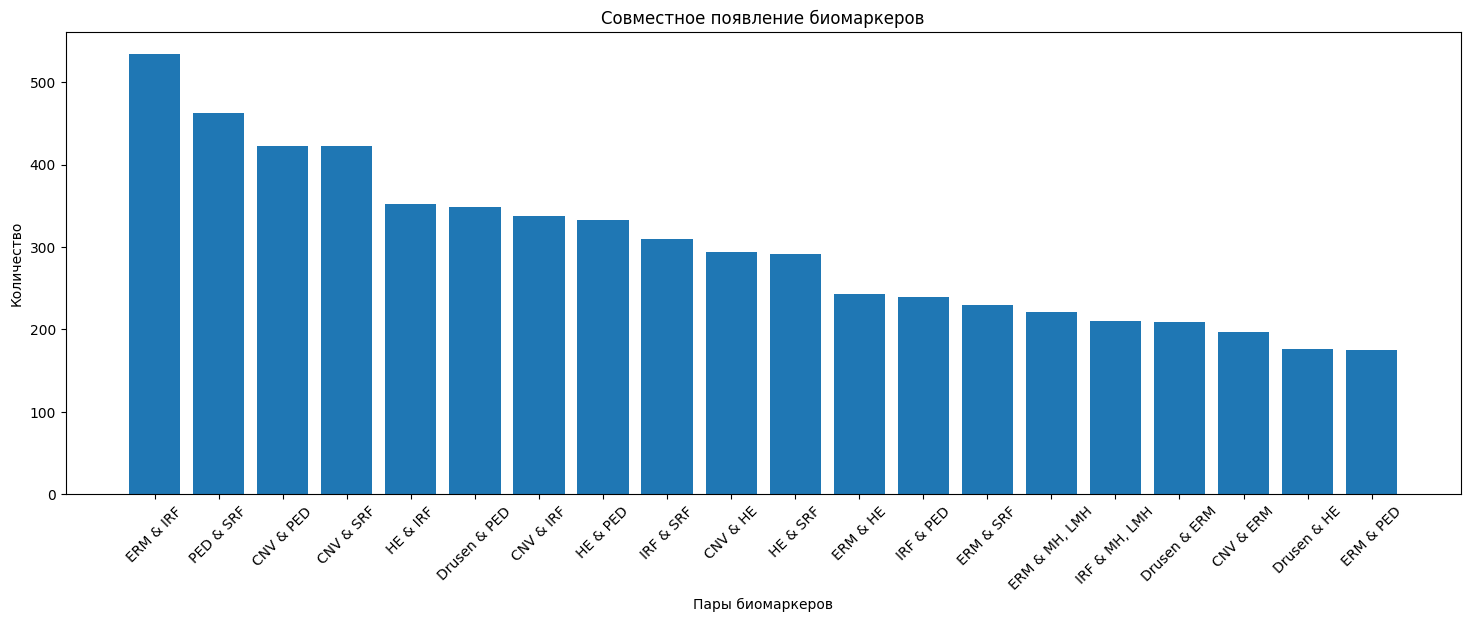

In [ ]:
plot_combined_biomarkers(dataset_no_id)

  # Предварительная обработка данных

In [1]:

class CustomDataLoader:
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = list(range(len(dataset)))
        if shuffle:
            np.random.shuffle(self.indices)

    def __iter__(self):
        self.i = 0
        return self

    def __next__(self):
        if self.i >= len(self.indices):
            raise StopIteration

        batch_indices = self.indices[self.i:self.i + self.batch_size]
        self.i += self.batch_size

        batch = [self.dataset[idx] for idx in batch_indices]

        images = [item[0] for item in batch]
        labels = [item[1] for item in batch]


        images = torch.stack(images)
        labels = torch.stack(labels)

        return images, labels, #img_name

    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size

In [ ]:
class OCTDataset(Dataset):
    def __init__(self, images_dir, labels_file, transform=None):
        """
        Args:
            images_dir (string): Directory with all the images.
            labels_file (string): Path to the XLSX file with labels.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images_dir = images_dir
        self.labels_df = pd.read_excel(labels_file)
        self.labels_df['id'] = self.labels_df['id'].astype(str)
        self.transform = transform
        self.valid_indices = self._find_valid_indices()
    def _find_valid_indices(self):
        """
        Find indices for which image files exist
        """
        valid_indices = []
        for idx in range(len(self.labels_df)):
            img_name = os.path.join(self.images_dir, f"{self.labels_df['id'].iloc[idx]}.jpg")
            if os.path.exists(img_name):
                valid_indices.append(idx)
        return valid_indices


    def __len__(self):
        return len(self.valid_indices)
    def __getitem__(self, idx):

        real_idx = self.valid_indices[idx]
        img_name = os.path.join(self.images_dir, f"{self.labels_df['id'].iloc[real_idx]}.jpg")

        try:
            image = Image.open(img_name).convert('RGB')
        except FileNotFoundError:
            print(f"Error: File not found at {img_name}")

            image = Image.new('RGB', (224, 224), color='black')
            labels = torch.zeros(12, dtype=torch.float32)
            if self.transform:
                image = self.transform(image)
            return image, labels

        labels = torch.tensor(self.labels_df[['IRF', 'SRF', 'HE', 'CNV', 'PED', 'Drusen', 'ERM', 'MH, LMH']].iloc[real_idx].values, dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, labels, img_name

In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize(180),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
data_transforms_train = transforms.Compose([
    transforms.Resize(180),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomPerspective(distortion_scale=0.1, p=0.3),
    transforms.ToTensor(),
    #transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

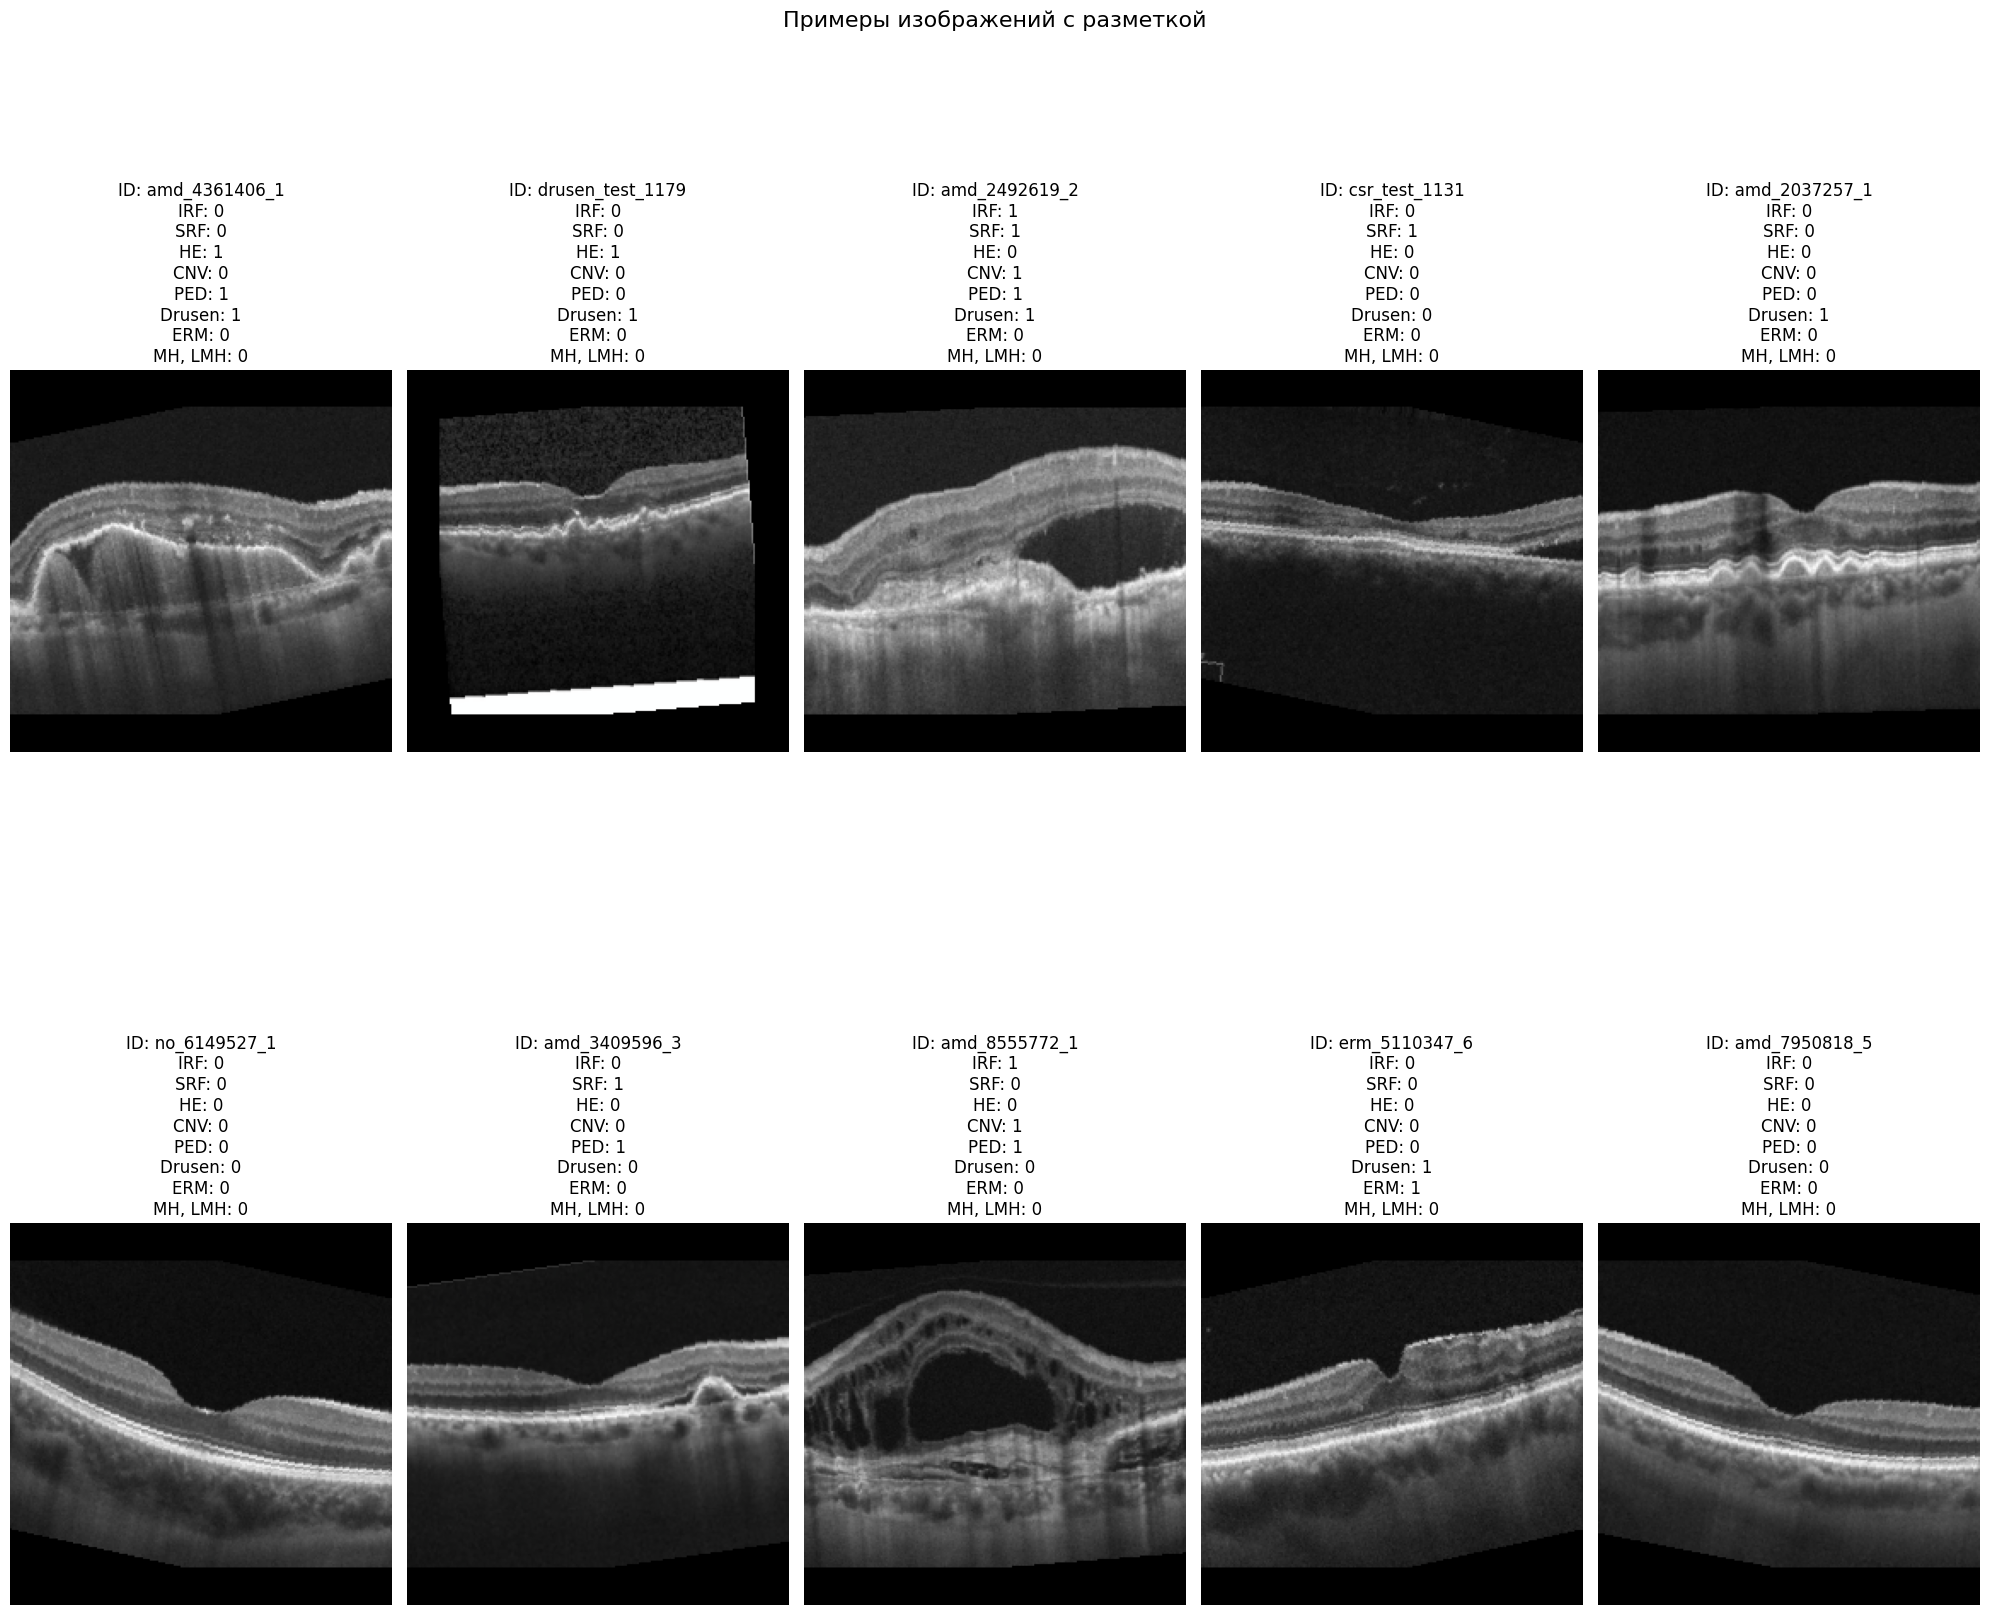

In [ ]:
# Создаем датасет с вашими трансформациями
dataset = OCTDataset(
    images_dir='/content/drive/MyDrive/data_jpg1',
    labels_file='/content/data_8_new.xlsx',
    transform=data_transforms_train  # ваши трансформы из предыдущего кода
)
# Выбираем 10 случайных индексов
indices = torch.randperm(len(dataset))[:10]

# Функция для денормализации изображения
def denormalize(image):
    """Денормализует изображение для отображения"""
    if isinstance(image, torch.Tensor):
        image = image.numpy()

    # Транспонируем из (C, H, W) в (H, W, C)
    image = image.transpose(1, 2, 0)

    # Параметры нормализации ImageNet
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    image = std * image + mean  # Денормализация
    image = np.clip(image, 0, 1)  # Ограничиваем значения [0, 1]
    return image

# Создаем grid для отображения
fig, axes = plt.subplots(2, 5, figsize=(20, 20))
fig.suptitle('Примеры изображений с разметкой', fontsize=16)

for i, idx in enumerate(indices):
    image, label, name = dataset[idx]

    # Денормализуем изображение
    image = denormalize(image)

    # Получаем метки
    label_names = ['IRF', 'SRF', 'HE', 'CNV', 'PED', 'Drusen', 'ERM', 'MH, LMH']
    label_text = '\n'.join([f'{n}: {v:.0f}' for n, v in zip(label_names, label.numpy())])

    # Отображаем
    ax = axes[i//5, i%5]
    ax.imshow(image)
    ax.set_title(f"ID: {dataset.labels_df['id'].iloc[dataset.valid_indices[idx]]}\n{label_text}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Создаем индексы для разделения
dataset = OCTDataset(
    images_dir='/content/drive/MyDrive/data_jpg1',
    labels_file='/content/data_8_new.xlsx',
    transform=None  # Временно ставим None
)

train_size = 0.9
test_size = 0.1

train_idx, test_idx = train_test_split(
    np.arange(len(dataset)),
    test_size=test_size,
    train_size=train_size,
    random_state=42
)

# Создаем отдельные датасеты с разными трансформациями
train_dataset = OCTDataset(
    images_dir='/content/drive/MyDrive/data_jpg1',
    labels_file='/content/data_8_new.xlsx',
    transform=data_transforms_train  # Применяем train-трансформации
)
train_dataset = Subset(train_dataset, train_idx) #фильтруем по индексам

test_dataset = OCTDataset(
    images_dir='/content/drive/MyDrive/data_jpg1',
    labels_file='/content/data_8_new.xlsx',
    transform=data_transforms  # Применяем test-трансформации
)
test_dataset = Subset(test_dataset, test_idx) #фильтруем по индексам


# Проверяем размеры
print(f"Размер тренировочного набора: {len(train_dataset)}")
print(f"Размер тестового набора: {len(test_dataset)}")

# Пример использования DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)



Размер тренировочного набора: 2822
Размер тестового набора: 314


In [ ]:
# Create CUSTOM data loaders
train_dataloader = CustomDataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True)

test_dataloader = CustomDataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False)

#Обучение модели.

## Загрузка весов модели

In [ ]:

from torchvision.models.resnet import ResNet101_Weights


model = models.resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)

# Заморозка слоев (fine-tuning)
for name, param in model.named_parameters():
    if "layer4" not in name and "fc" not in name:
        param.requires_grad = False


num_classes = 8
num_features = model.fc.in_features

# Новый блок fully connected с Dropout и BatchNorm
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),  # Dropout с вероятностью 50%
    nn.Linear(num_features, 512),  # Промежуточный слой
    nn.BatchNorm1d(512),  # Нормализация
    nn.ReLU(inplace=True),  # Активация
    nn.Dropout(p=0.3),  # Еще один Dropout
    nn.Linear(512, num_classes)  # Финальный слой
)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


print(model)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:02<00:00, 66.1MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Обучение и оценка модели

In [ ]:
learning_rate = 1e-7
num_epochs = 20 # yf 20 на 20 эпохах
criterion = nn.BCEWithLogitsLoss()  # Для многозначной классификации
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    #optimizer,
    #mode='min',  # Режим "min", так как мы следим за loss
    #factor=0.1,  # Множитель, на который уменьшаем learning rate (умножаем на 0.1)
   # patience=5,  # Количество эпох без улучшений, после которых уменьшаем learning rate
   # verbose=True  # Выводить сообщения об уменьшении learning rate
#)
# 12. Цикл обучения
best_val_loss = float('inf')
for epoch in range(num_epochs):
    # Обучение
    model.train()  # Устанавливаем модель в режим обучения
    running_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.float().to(device)  # Убедитесь, что метки имеют тип float для BCEWithLogitsLoss

        # Обнулите градиенты
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Обратное распространение и оптимизация
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}')

     # Валидация
    model.eval()
    all_preds = []
    all_labels = []
    running_corrects = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.float().to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            preds = (outputs > 0.35).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            val_running_loss += loss.item() * images.size(0)

            running_corrects += torch.sum(preds == labels.data).item()

    epoch_acc = running_corrects / (len(test_dataset) * num_classes)
    val_epoch_loss = val_running_loss / len(test_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Val Accuracy: {epoch_acc:.4f}, Val Loss: {val_epoch_loss:.4f}')
    if val_epoch_loss < best_val_loss:  # Если текущий loss на валидации меньше лучшего
        best_val_loss = val_epoch_loss  # Обновляем лучшее значение
        torch.save(model.state_dict(), 'modelВ1.pth')  # Сохраняем state_dict модели
        #print(f"Epoch {epoch+1}: Best model saved with Val Loss: {best_val_loss:.4f}")
    #scheduler.step(val_epoch_loss)

print("Fine-tuning complete!")

Epoch [1/5], Train Loss: 0.1383
Epoch [1/5], Val Accuracy: 0.9061, Val Loss: 0.2406
Epoch [2/5], Train Loss: 0.1402
Epoch [2/5], Val Accuracy: 0.9033, Val Loss: 0.2413
Epoch [3/5], Train Loss: 0.1390
Epoch [3/5], Val Accuracy: 0.9045, Val Loss: 0.2409
Epoch [4/5], Train Loss: 0.1384
Epoch [4/5], Val Accuracy: 0.9033, Val Loss: 0.2413
Epoch [5/5], Train Loss: 0.1381
Epoch [5/5], Val Accuracy: 0.9053, Val Loss: 0.2410
Fine-tuning complete!


In [ ]:
 # Вычисление метрик по классам
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
for i in range(num_classes):
        precision = precision_score(all_labels[:, i], all_preds[:, i])
        recall = recall_score(all_labels[:, i], all_preds[:, i])
        f1 = f1_score(all_labels[:, i], all_preds[:, i])
        print(f'Class {i}: Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}')

Class 0: Precision = 0.9610, Recall = 0.8132, F1 = 0.8810
Class 1: Precision = 0.8861, Recall = 0.7955, F1 = 0.8383
Class 2: Precision = 0.8571, Recall = 0.5000, F1 = 0.6316
Class 3: Precision = 0.9016, Recall = 0.8462, F1 = 0.8730
Class 4: Precision = 0.9036, Recall = 0.8242, F1 = 0.8621
Class 5: Precision = 0.9000, Recall = 0.6983, F1 = 0.7864
Class 6: Precision = 0.9016, Recall = 0.5140, F1 = 0.6548
Class 7: Precision = 0.9231, Recall = 0.8276, F1 = 0.8727


In [ ]:
micro_f1 = f1_score(all_labels, all_preds, average='micro')
macro_f1 = f1_score(all_labels, all_preds, average='macro')
print(f'Micro F1: {micro_f1:.4f}, Macro F1: {macro_f1:.4f}')

Micro F1: 0.7980, Macro F1: 0.8000


In [ ]:
torch.save(model.state_dict(), 'model34_8_1.pth')
print("Модель сохранена в model.pth")

Модель сохранена в model.pth


# Проверка на Валидационном наборе

In [ ]:
val_dataset = OCTDataset(
    images_dir='/content/drive/MyDrive/ОКТ макула (копия)',
    labels_file='/content/OCT_VAL 8.xlsx',
    transform=data_transforms
)

val_dataloader = CustomDataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False)


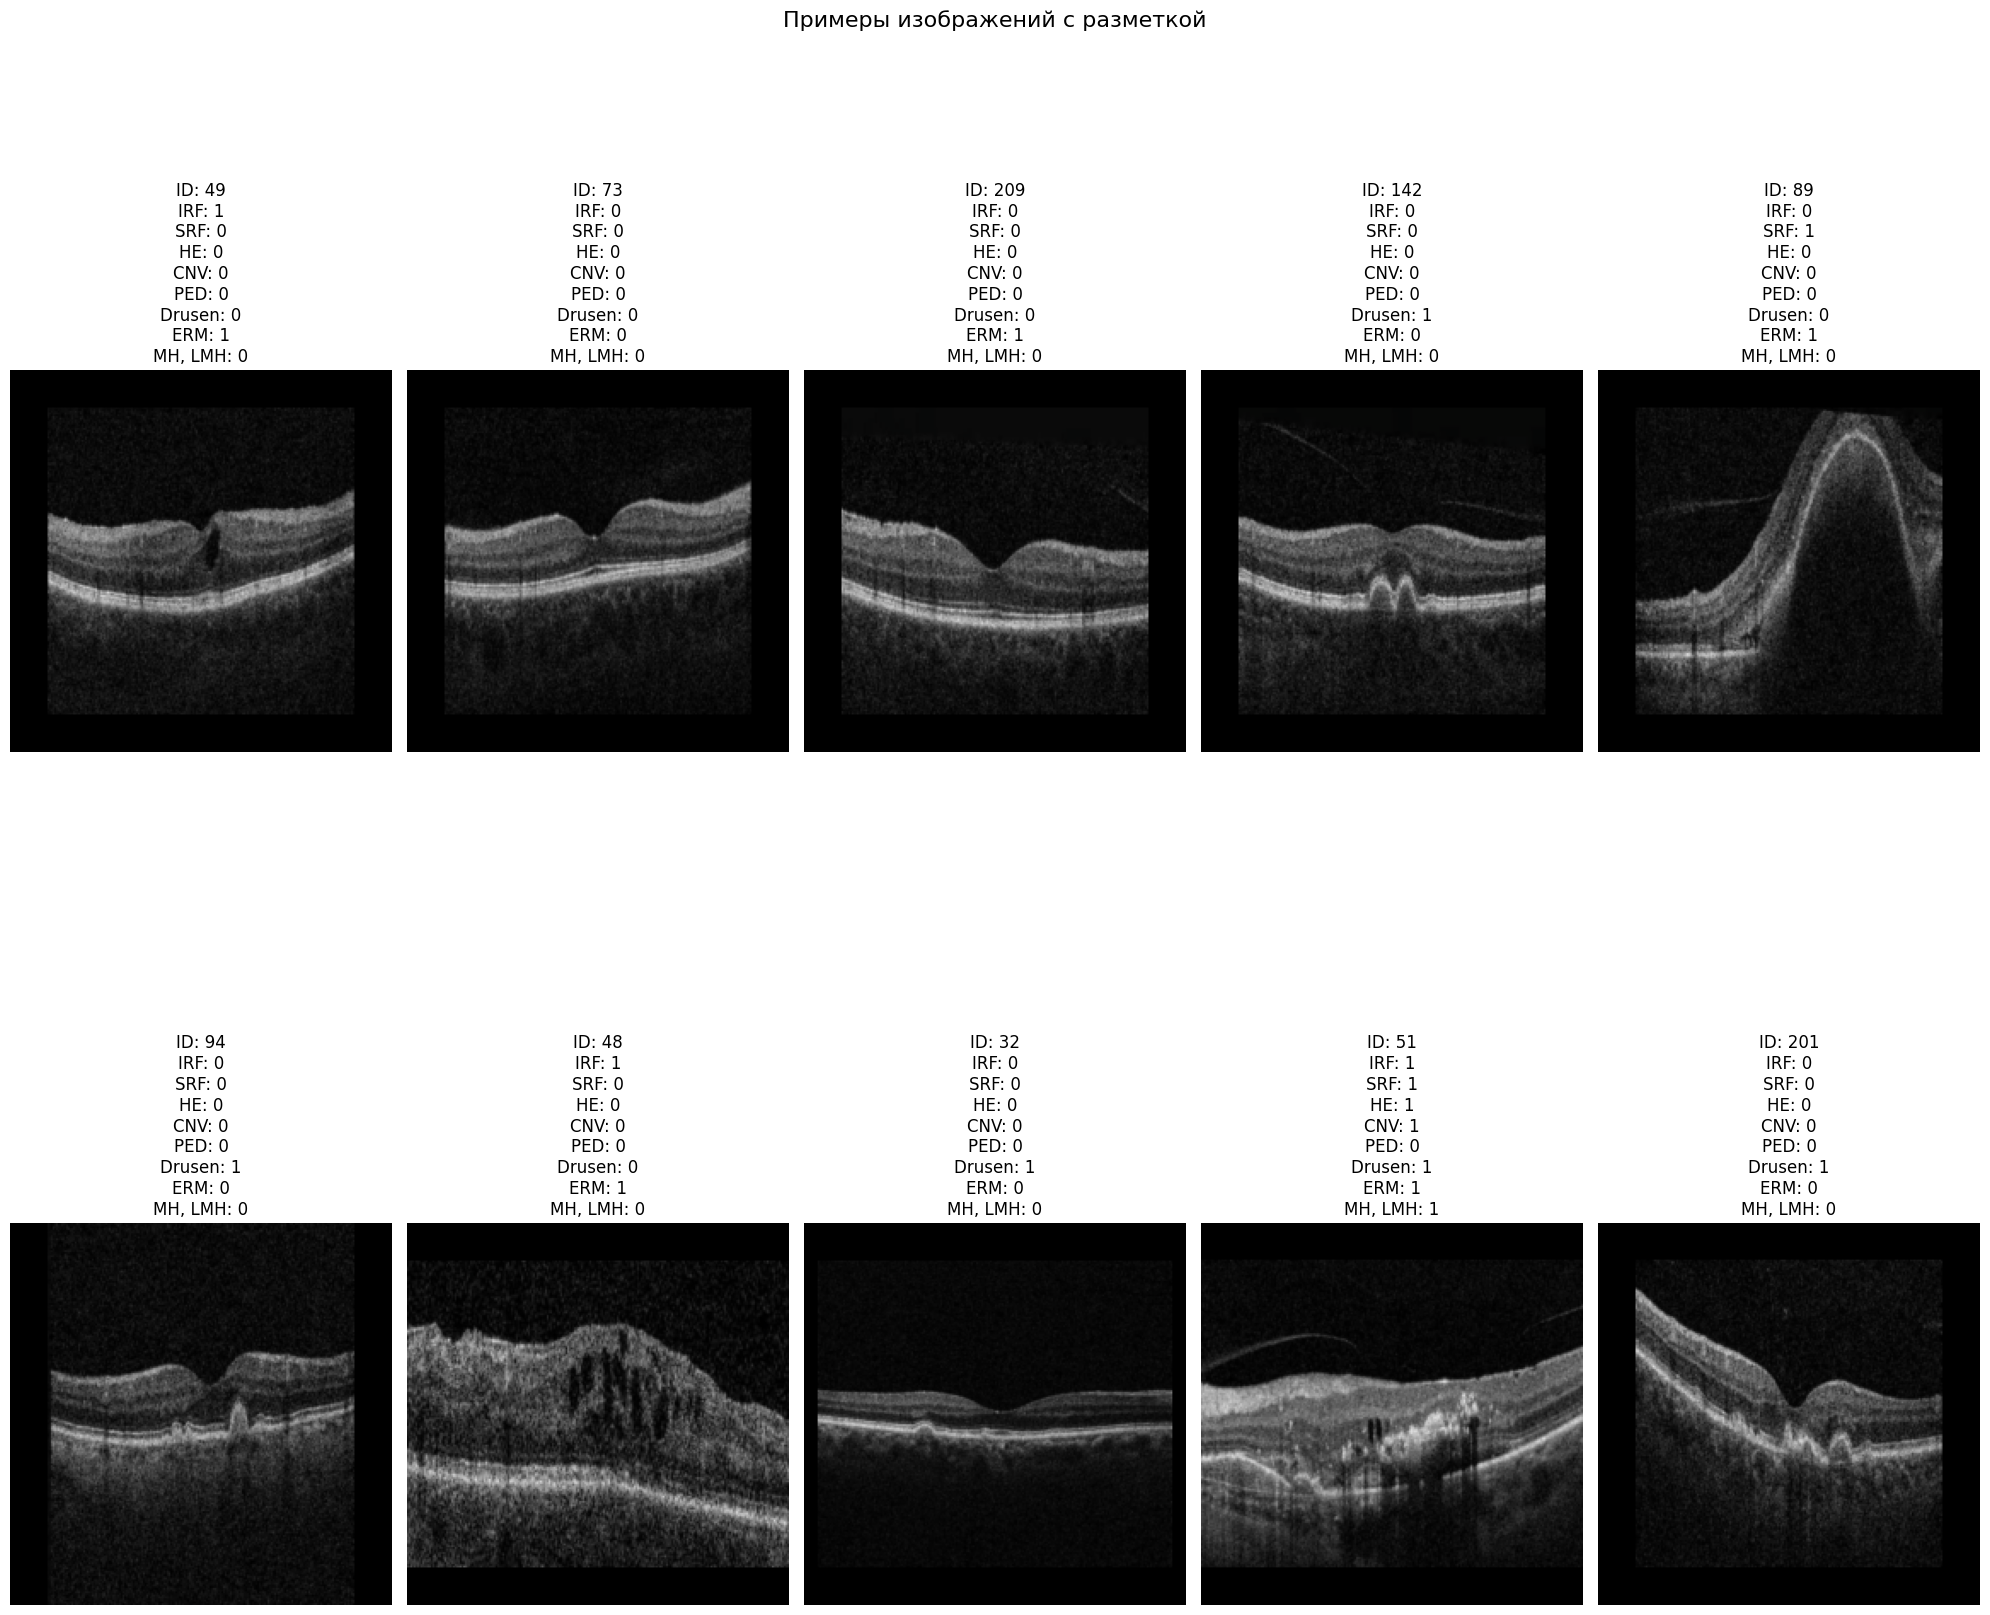

In [ ]:
# Выбираем 10 случайных индексов
indices = torch.randperm(len(val_dataset))[:10]

# Создаем grid для отображения
fig, axes = plt.subplots(2, 5, figsize=(20, 20))
fig.suptitle('Примеры изображений с разметкой', fontsize=16)

for i, idx in enumerate(indices):
    image, label,name = val_dataset[idx]

    # Денормализуем изображение
    image = denormalize(image)

    # Получаем метки
    label_names = ['IRF', 'SRF', 'HE', 'CNV', 'PED', 'Drusen', 'ERM', 'MH, LMH']
    label_text = '\n'.join([f'{n}: {v:.0f}' for n, v in zip(label_names, label.numpy())])

    # Отображаем
    ax = axes[i//5, i%5]
    ax.imshow(image)
    ax.set_title(f"ID: {val_dataset.labels_df['id'].iloc[val_dataset.valid_indices[idx]]}\n{label_text}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import torch

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)


        preds = (outputs > 0.25).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Вычисляем метрики
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

#  Вычисляем общую accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

#  Вычисляем метрики для каждого класса
for i in range(num_classes):
    precision = precision_score(all_labels[:, i], all_preds[:, i], zero_division=0)
    recall = recall_score(all_labels[:, i], all_preds[:, i])
    f1 = f1_score(all_labels[:, i], all_preds[:, i])
    print(f'Class {i}: Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}')

Accuracy: 0.4936
Class 0: Precision = 0.9176, Recall = 0.8571, F1 = 0.8864
Class 1: Precision = 0.8625, Recall = 0.7841, F1 = 0.8214
Class 2: Precision = 0.7200, Recall = 0.5000, F1 = 0.5902
Class 3: Precision = 0.8254, Recall = 0.8000, F1 = 0.8125
Class 4: Precision = 0.9429, Recall = 0.7253, F1 = 0.8199
Class 5: Precision = 0.9111, Recall = 0.7069, F1 = 0.7961
Class 6: Precision = 0.8947, Recall = 0.4766, F1 = 0.6220
Class 7: Precision = 0.9200, Recall = 0.7931, F1 = 0.8519


In [ ]:
micro_f1 = f1_score(all_labels, all_preds, average='micro')
macro_f1 = f1_score(all_labels, all_preds, average='macro')
print(f'Micro F1: {micro_f1:.4f}, Macro F1: {macro_f1:.4f}')

Micro F1: 0.7752, Macro F1: 0.7750


In [ ]:
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_bootstrap_ci_multilabel(y_true, y_pred, n_iterations=1000, confidence_interval=95):
    """
    Вычисляет бутстрапные доверительные интервалы в формате "mean ± interval".
    Возвращает словарь с:
    - средними значениями метрик (mean)
    - полушириной доверительного интервала (interval)
    - отформатированными строками (print_ci)
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n_samples = len(y_true)
    num_classes = y_true.shape[1]

    # Инициализация массивов
    precision_per_class = np.zeros((n_iterations, num_classes))
    recall_per_class = np.zeros((n_iterations, num_classes))
    f1_per_class = np.zeros((n_iterations, num_classes))

    micro_precision, micro_recall, micro_f1 = np.zeros(n_iterations), np.zeros(n_iterations), np.zeros(n_iterations)
    macro_precision, macro_recall, macro_f1 = np.zeros(n_iterations), np.zeros(n_iterations), np.zeros(n_iterations)

    for i in range(n_iterations):
        indices = resample(np.arange(n_samples), replace=True, n_samples=n_samples)
        y_true_sample = y_true[indices]
        y_pred_sample = y_pred[indices]

        precision_per_class[i] = precision_score(y_true_sample, y_pred_sample, average=None, zero_division=0)
        recall_per_class[i] = recall_score(y_true_sample, y_pred_sample, average=None, zero_division=0)
        f1_per_class[i] = f1_score(y_true_sample, y_pred_sample, average=None, zero_division=0)

        micro_precision[i] = precision_score(y_true_sample, y_pred_sample, average='micro', zero_division=0)
        micro_recall[i] = recall_score(y_true_sample, y_pred_sample, average='micro', zero_division=0)
        micro_f1[i] = f1_score(y_true_sample, y_pred_sample, average='micro', zero_division=0)

        macro_precision[i] = precision_score(y_true_sample, y_pred_sample, average='macro', zero_division=0)
        macro_recall[i] = recall_score(y_true_sample, y_pred_sample, average='macro', zero_division=0)
        macro_f1[i] = f1_score(y_true_sample, y_pred_sample, average='macro', zero_division=0)

    alpha = (100 - confidence_interval) / 2
    percentiles = (alpha, 100 - alpha)

    def _get_ci(metric_values):
        mean = np.mean(metric_values)
        lower, upper = np.percentile(metric_values, percentiles)
        interval = (upper - lower) / 2
        return {
            'mean': mean,
            'interval': interval,
            'print_ci': f"{mean:.4f} ± {interval:.4f}"
        }

    result = {
        'per_class': {},
        'micro': {},
        'macro': {}
    }

    # Для каждого класса
    for class_id in range(num_classes):
        result['per_class'][class_id] = {
            'precision': _get_ci(precision_per_class[:, class_id]),
            'recall': _get_ci(recall_per_class[:, class_id]),
            'f1': _get_ci(f1_per_class[:, class_id])
        }

    # Для микро-усреднения
    result['micro'] = {
        'precision': _get_ci(micro_precision),
        'recall': _get_ci(micro_recall),
        'f1': _get_ci(micro_f1)
    }

    # Для макро-усреднения
    result['macro'] = {
        'precision': _get_ci(macro_precision),
        'recall': _get_ci(macro_recall),
        'f1': _get_ci(macro_f1)
    }

    return result



ci = calculate_bootstrap_ci_multilabel(all_labels, all_preds)
print("=== Per-class metrics ===")
for class_id in ci['per_class']:
      print(f"\nClass {class_id}:")
      print(f"Precision: {ci['per_class'][class_id]['precision']['print_ci']}")
      print(f"Recall:    {ci['per_class'][class_id]['recall']['print_ci']}")
      print(f"F1-score:  {ci['per_class'][class_id]['f1']['print_ci']}")
print("\n=== Micro-averaged metrics ===")
print(f"Precision: {ci['micro']['precision']['print_ci']}")
print(f"Recall:    {ci['micro']['recall']['print_ci']}")
print(f"F1-score:  {ci['micro']['f1']['print_ci']}")

print("\n=== Macro-averaged metrics ===")
print(f"Precision: {ci['macro']['precision']['print_ci']}")
print(f"Recall:    {ci['macro']['recall']['print_ci']}")
print(f"F1-score:  {ci['macro']['f1']['print_ci']}")


=== Per-class metrics ===

Class 0:
Precision: 0.9618 ± 0.0417
Recall:    0.8126 ± 0.0807
F1-score:  0.8803 ± 0.0545

Class 1:
Precision: 0.8854 ± 0.0668
Recall:    0.7928 ± 0.0825
F1-score:  0.8357 ± 0.0575

Class 2:
Precision: 0.8541 ± 0.1077
Recall:    0.5015 ± 0.1157
F1-score:  0.6300 ± 0.1015

Class 3:
Precision: 0.9026 ± 0.0781
Recall:    0.8480 ± 0.0888
F1-score:  0.8735 ± 0.0624

Class 4:
Precision: 0.9044 ± 0.0631
Recall:    0.8235 ± 0.0776
F1-score:  0.8614 ± 0.0523

Class 5:
Precision: 0.8987 ± 0.0592
Recall:    0.6980 ± 0.0858
F1-score:  0.7848 ± 0.0623

Class 6:
Precision: 0.8991 ± 0.0733
Recall:    0.5150 ± 0.0906
F1-score:  0.6536 ± 0.0817

Class 7:
Precision: 0.9177 ± 0.1035
Recall:    0.8284 ± 0.1474
F1-score:  0.8686 ± 0.1023

=== Micro-averaged metrics ===
Precision: 0.9048 ± 0.0256
Recall:    0.7137 ± 0.0354
F1-score:  0.7978 ± 0.0263

=== Macro-averaged metrics ===
Precision: 0.9030 ± 0.0276
Recall:    0.7275 ± 0.0378
F1-score:  0.7985 ± 0.0293
